<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/cabecera.png';">

## **Masterclass: Introducción a la IA Generativa en Imágenes**

## Setup

Para este taller vamos a emplear colab, así que vamos allá.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/albertoromv/DS_Online_Febr25_Exercises/blob/main/Masterclasses/MC_07_Sprint_16_Intro_Generativa_Imagenes/Intro_Generativa_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Comprobamos:  
- Versión de Python 3.7 o superior
- Versión de Sklearn 1.0.1 o superior
- Versión de TensorFlow 2.8 o superior

In [ ]:
import sys
from packaging import version
import sklearn
import tensorflow as tf


assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert version.parse(tf.__version__) >= version.parse("2.8.0")

Algunos ajustes para cuando lancemos nuestro entrenamiento de redes GAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import time, sleep


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Comprobación de si tenemos GPU a mano, porque si no ya te puedes ir a tomar un desayuno, comida o cena.

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [ ]:
#@markdown Chequea el tipo de GPU y la memoria virtual disponible
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15092 MiB


List@s para empezar, en este taller utilizaremos el dataset del Fashion MNIST (FMNIST), ese gran amigo nuestro de ropas y complementos.

In [ ]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Y un poco de código para poder pintar las imágenes:

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


## ¿Cómo hemos llegado a generar imágenes con RNN?

Lo primero un poco de historia sobre las redes generativas de imágenes. Todo empieza cuando se plantea la posibilidad de encontrar representaciones "latentes" de nuestras imágenes (¿os acordáis de la PCA?), es decir reducidas y compactas en un espacio de menor dimensionalidad.  

Esa línea de investigación nos ha llevado en relativamente poco tiempo a crear arquitecturas cada vez más avanzadas y con mejores resultados. En este taller explicaremos los modelos más importantes hasta la fecha, y algunas de sus variaciones:

* **Autoencoders**  

* **GANs** (Generative Adversarial Networks)  

* **Diffusion Models** (o más correctamente DDPM, Denoising Diffusion Probabilistic Model, que entrenados con condicionamiento de texto dan lugar a: Stable XL, Midjourney, DALL-E, etc)  



## Autoencoders

Son **redes neuronales** que constan de un ***encoder*** (o red de reconocimiento) y un ***decoder*** (red de generación) generalmente simétricos **que se entrena con una tarea semi-supervisada o auto-supervisada**. Básicamente, reproducir la entrada, así tal como suena.

La idea es que el encoder aprenda una representación (embedding, espacio latente, etc) de la entrada que luego pueda servir para ser reconstruida. Es un extractor genérico de features que puedes llevarte al problema que quieras, y que además con un poco de magia también puede inventarse entradas (pero eso no lo vamos a ver).


<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/simple_autoencoder.png';"
     alt="Diagrama de autoencoder" width="600"/>

*Figura: Stacked Autoencoder (Stacked -> Varias capas ocultas en Encoder y Decoder)*

Lo que se hace es "fastidiar" al encoder (pocas neuronas, meterle ruido, dropout incluso en inferencia, etc) lo que le fuerza a encontrar una representación lo más eficiente posible.

Se usan para cosas como por ejemplo:  

- PCA
- Latent Analysis
- Feature Extraction. Ejemplo, autoetiquetador: Entrenas el autoencoder, te llevas el encoder como feature extraction para etiquetar imágenes
- Eliminar ruido a imágenes
- Y finalmente... Generación de imágenes, veamos cómo



### Ejemplo: Análisis Latente/Reducción de dimensionalidad

Vamos a reducir las 28*28 features de las imágenes aplanadas del FMNIST a 30 y luego vamos a ver cómo de buena es la clusterización, reduciendo a su vez linealmente esas 30 a 2 y pintando el cluster resultante.

In [ ]:
X_train.shape

(55000, 28, 28)

In [ ]:
### Ejemplo: Reducción de dimensionalidad, representación latente (análisis latente)

tf.random.set_seed(42)
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")

history = stacked_ae.fit(X_train,
                         X_train,
                         epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0348 - val_loss: 0.0187
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0180 - val_loss: 0.0169
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0164 - val_loss: 0.0159
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 12/20
1719/1719 ━━━━━━━

Observa la forma de construirlo, es así para tener acceso al encoder por separado.  

Vamos a ver que tal funciona nuestro Autoencoder desde el punto de vista de "compresión"/"reconstrucción" de imágenes (recuerda el ejercicio de la PCA y las cámaras del casino).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


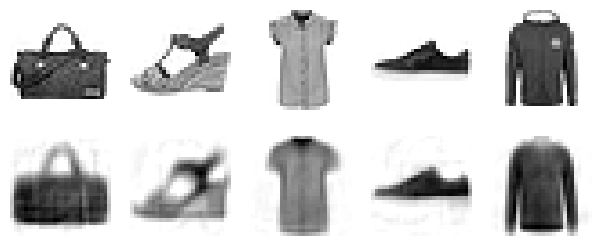

In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5, origin = 0):
    n_images = n_images if (origin + n_images) < images.shape[0] else max(1,images.shape[0]-origin)
    reconstructions = np.clip(model.predict(images[origin:origin + n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[origin + image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae, origin = np.random.randint(0,X_valid.shape[0]))
plt.show()

Vale, es verdad que la descompresión es mala, pero veamos qué pasa si proyectamos esas 30 nuevas dimensiones del espacio latente en 2.  

En este caso no vamos a usar nuestra querida PCA sino otra aproximación llamada t-SNE, que viene de perlas para pintar clusters de alta dimensionalidad.

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


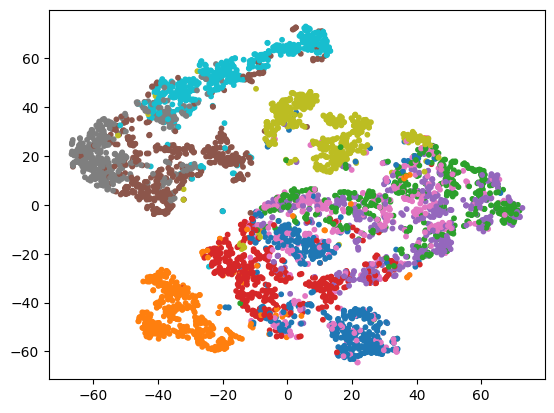

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

De acuerdo, no se entiende nada, pero si adaptados este código de Aurelien Geron (que a su vez está adapta de los [ejemplos de sklearn](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

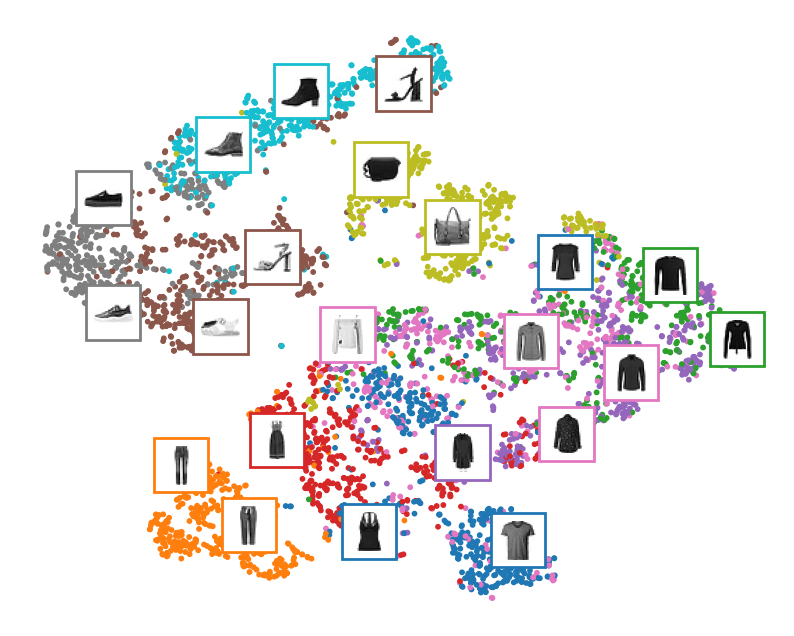

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

### Evolución de los Autoencoders

Los autoencoders evolucionaron desde el modelo sencillo (también llamado *stacked* o apilado, por tener varias capas en encoder y decoder), hasta los VAE (Variational Autoencoders), y de por medio también aparecieron los Convolutional Autoencoders, que como su nombre indica usan capas convolucionales.  

Estas dos variantes, los VAE y el uso de capas convolucionales, están detrás de los dos grandes saltos dentro de la generativa de imágenes.  

Muy resumidamente y empezando por los **VAE**, estos introducen un truco que es que lo que alimenta al decoder no es directamente la salida de las neuronas del encoder sino que a partir de esa salida se genera otra a la que se fuerza a que pertenezca a una distribución gaussiana de la anterior (¿cómorl?). Dicho llanamente, es como si al introducir una imagen le estuviéramos diciendo al VAE que aprenda sobre las variantes de la misma.

Una vez entrenado, se probó a separar el decoder y a introducirle entradas aleatorias (pero que sigan una distribución gaussiana) y, ¡oh, sorpresa!, los decoders eran capaces de inventarse imágenes con cierto sentido.

Los Convolutional Autoencoders nacieron de la hipótesis de construir un Autoencoder con **capas convolucionales a la entrada del encoder** (Conv2D), pero para poder hacerlo y que la idea funcionara era necesario también invertir las capas y **hacer posible una construcción simétrica en el decoder.**  

Para ello se desarrollaron unas capas denominadas **convolucionales transpuestas** (Conv2DTranspose), que son capaces de recibir la salida de las capas convolucionales del encoder y devolver la salida de sus filtros con la resolución original de entrada.

<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/transposed_Deconvolution.webp';"
     alt="Inversa y Transpuesta de una convolucional" height="200"/> 

En cuanto tuvimos estas circunstancia a alguien se le ocurrió que a lo mejor se podían poner a competir a dos autoencoders entre sí, y así nacieron las Generative Adversarial Networks o GAN.  


# Generative Adversarial Networks o GANs

Las Redes Adversarias Generativas consisten en dos redes neuronales con misiones contrapuestas.  

La primera red, denominada Generator o Generador, tiene como objetivo crear instancias sintéticas (falsas) que la segunda red debe clasificar como verdaderas. La misión de la segunda red, denominada Discriminator o Discriminador, es aprender a reconocer esas instancias sintéticas falsas.  

<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/GAN.jpg';"
     alt="Diagrama sencillo GAN" width="1000"/>

Para entenderlas un poco mejor, merece la pena conocer cómo se entrenan porque no es igual que en las redes vistas hasta ahora:  

1. Al batch de imágenes reales se le añade otro batch de imágenes falsas. Estas imágenes falsas se crean generando ruido gaussiano. Para ello generamos tantas "features" (llamadas codings) como queramos darle de comer al Generador. Con dichos codings nuestro Generador creará tantas imágenes como haga falta, haciendo pasar la entrada aleatoria por sus capas (piensa que las primeras veces las "imágenes" sintéticas serán un manchurrón porque los pesos del Generador no están entrenados) y las mezclamos con el batch de imágenes reales.  

2. A las imágenes reales les asignamos la clase 1, por ejemplo, y a las falsas la clase 0. Con esas etiquetas entrenamos sólo el Discriminador (que en estos primeros entrenamientos lo tendrá muy fácil).  

3. Una vez entrenado el discriminador, lo congelamos, es decir evitamos que sus capas sean entrenadas en la siguiente fase del entrenamiento.  

4. Con el discriminador entrenado y congelado, usamos toda la red GAN para entrenar, pero como hemos congelado el discriminador, sólo se entrenarán los pesos del Generador... ingenioso, ¿verdad? 

5. Pero, ¿cómo hacemos para que entrene el Generador? Creamos nuevos codings de ruido gaussiano (nuevos para que el Discriminador no los haya visto nunca) que pasamos como entradas al Generador. El Generador generará nuevas imágenes falsas, pero en esta ocasión las etiquetamos como reales (clase 1) y las pasamos por el Discriminator. Ahora, cada vez que el Discriminador diga que algo es falso (clase 0) podremos retropropagar el error de forma que los pesos de las capas del Generador se irán configurando para aprender a engañar al Discriminador.

6. Repitiendo este proceso en cada batch, y a lo largo de sucesivas épocas, conseguiremos que nuestro Generador creé imágenes que engañen al Discriminador, pero si lo piensas al Generador NUNCA le hemos mostrado las imágenes reales. Aprende a generar solamente por retropropagación.

Y voilá, veámoslo con código (pero por simplicidad nuestra GAN no incluye capas convolucionales ni convolucionales traspuestas).

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 30

# Creamos un modelo para el discriminador y un modelo para el generador.
# Una vez entrenado este último nos permitirá crear prendas (solo de forma aleatoria, no podremos guiar el proceso)
generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(100, activation="selu"),
    tf.keras.layers.Dense(150, activation="selu"),
    tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28]) # Convertimos la salida del generador en "imágenes" de 28x28
])

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation="selu"),
    tf.keras.layers.Dense(100, activation="selu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

gan = tf.keras.models.Sequential([generator, discriminator])


In [ ]:
# Primer truco para entrenar, creamos un modelo para el discriminador y un modelo con generador y discriminador, las capas del discriminador las "congelaremos" para entrenar el generador
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    training_time = []
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        epoch_t_zero = time()
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        
        for X_batch in dataset:
            # Fase 1 - Entrenamiento del Discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size]) # Generamos unas tiradas de dados para hacer las imágenes falsas
            generated_images = generator(noise) # Generamos las imágenes fake pasándolas por el Generator tal cual esté en ese momento, (a medida que se vayan generando batches irá mejorando)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # Mezclamos falsas (generated_images) y reales (X_batch)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # Asignamos 0 a las falsas y 1 a las reales
            discriminator.trainable = True # Descongelamos los pesos del discriminador
            discriminator.train_on_batch(X_fake_and_real, y1) # Entrenamos, utilizando el método especial de entrenar en un sólo batch y aprovechamos que los modelos se entrenan progresivamente :-), no se pierden los pesos al volver a entrenar
            
            # Fase 2 - Entrenamiento del Generador
            noise = tf.random.normal(shape=[batch_size, codings_size]) # Nuevas tiradas para no dar ventaja al Discriminator, y que serán la entrada a toda la GAN
            y2 = tf.constant([[1.]] * batch_size) # Preparamos la trampa para el Discriminator, le vamos a decir que todas son reales (por eso tenemos que congelar los pesos del Discriminator sino aprendería a decir que sí a todas las imágenes fake)
            discriminator.trainable = False  # Congelamos los pesos del discriminador para entrenar el generador
            gan.train_on_batch(noise, y2) # Utilizamos el modelo GAN, que en realidad sólo está entrenando las capas del Generator
        # extra code — plot images during training
        training_time.append(time() - epoch_t_zero)
        plot_multiple_images(generated_images.numpy(), 8) # Para ver como el Generator va mejorando
        clear_output(wait = True)
        print("Dur epoca:", training_time[-1])
        plt.show()
    print("Duracion entrenamiento:", np.sum(training_time))


Dur epoca: 17.165931940078735


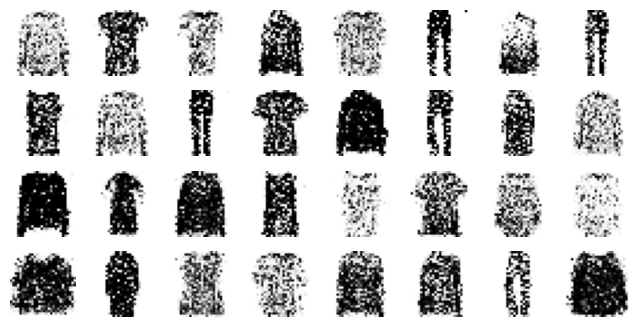

Duracion entrenamiento: 192.2117395401001


In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

Y ahora que ya lo hemos entrenado, juguemos un poco

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


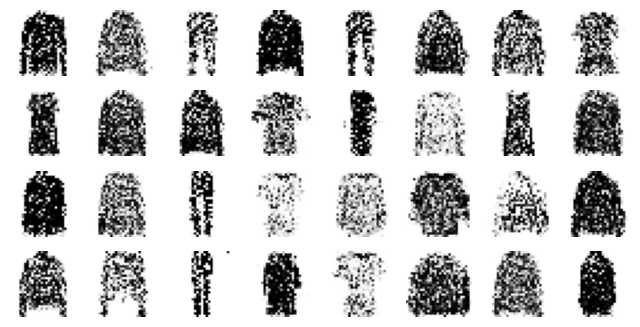

In [ ]:
# extra code – this cell generates and saves Figure 17–15
plot_multiple_images(generated_images, 8)
#save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

## Evolución de las GANs: el camino hacia las StyleGANs

__Deep Convolutional GANs (DCGAN)__: Las GAN que hemos visto usan capas densas, lo siguiente fue incluir capas Convolucionales Transpuestas en el Generator y Convolucionales al Discriminator y hacer algunos truquis para que el entrenamiento fuera estable (no se llegaran a "acuerdos" entre Discriminator y Generator, como, por ejemplo, lo que se conoce como Mode Collapse).  

__Progressive DCGAN__: En 2018 los investigadores de Nvidia introdujeron nuevas mejoras a las GAN, siendo la principal una nueva arquitectura dinámica de la red en entrenamiento (es decir, se van añadiendo capas convolucionales a medida que se entrena) además de otros elementos para hacerla estable.

__StyleGANs__: No mucho después se introdujeron cambios que permitieron un salto cualitativo destacado. Básicamente cambiaron la arquitectura del Generator de forma que ahora contenía dos partes en su interior: una Mapping Network y una Synthesis Network (ambas entrenables)



<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/styleGAN.webp';"
     drawing = "Diagrama de un Generator de una StyleGAN" width ="600" />

Lo diferencial en las StyleGAN es que la Mapping Network es como un "superembedding" de las imágenes, creado antes de sintetizarlas, que da un vector por imagen base (w, también llamado style vector). Este vector se pasa por las capas de transformación (A) que generan otros subvectores que ya sí entran el módulo de la _Synthesis Network_ que genera la imagen aleatoria.  

Lo potente, además de que se generen imágenes cada vez más realistas, es que una vez entrenado este Generator se pueden tocar las cajas A y sobre una misma imagen generada podemos cambiar las características (el color del pelo, la edad, el humor, etc). De hecho también podemos cambiar la imagen de partida tocando el vector w.  
  
Lo que no podemos es alterar una foto que no haya sido generada por el sistema (ten en cuenta que le hemos dado "codings" de ruido gaussiano aleatorio para "comer"), pero sí hay aplicaciones capaces de sacar el vector w de una imagen dada y posteriormente aplicar una red de _Synthesis_ preentrenada.  

Aquí tienes algunos recursos que aplican StyleGAN para generación de imágenes:  

* [Alquileres](https://thisrentaldoesnotexist.com)
* [Caras](https://thispersondoesnotexist.com)
* [Which Face is Real](http://www.whichfaceisreal.com/)

# Diffusion Models

Por último llegamos a los Diffusion Models o Modelos de Difusión. Estos modelos no son GAN, son redes que durante su entrenamiento reciben imágenes a las que se les ha aplicado ruido de forma progresiva. De esta manera, el objetivo principal de los modelos de difusión es que la red aprenda a predecir y eliminar el ruido añadido en cada paso del proceso.  

Posteriormente, cuando alimentamos estos modelos con ruido aleatorio puro, sin ninguna imagen previa, la red aplica el proceso inverso: predice iterativamente qué imagen podría estar "oculta" bajo ese ruido y va eliminándolo paso a paso mediante múltiples iteraciones de denoising. Al final de este proceso iterativo aparece ante nosotros una imagen completamente nueva que la red ha generado basándose en los patrones aprendidos durante el entrenamiento. Al igual que en los VAE, la imagen resultante no es ninguna de las imágenes de entrenamiento, sino una nueva combinación de características que el modelo ha aprendido a generar.

El proceso sería algo así:

- Imagen_X + un poco de ruido -> Imagen_1 (la red tiene que aprender a predecir el "poco de ruido" que se añadió).  

- Imagen_1 + otro poco de ruido -> Imagen_2 (la red tiene que aprender a predecir el "otro poco de ruido" que se añadió).  

- Imagen_2 + más poco ruido -> Imagen_3 (la red tiene que aprender a predecir "más poco ruido" que se añadió).  

- ...  

- ...  

- ...  

- Imagen_3999 + poquito final de ruido -> Imagen_4000  (que ahora será un buen manchurrón de ruido completo, indistinguible para el ojo humano) -> la red tiene que aprender a predecir el "poquito final de ruido" que se añadió.  

<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/diffusion_forward.png';"
     alt ="Proceso forward de diffusion" width = "800"/>

Si hacemos esto con millones de imágenes, el modelo estará preparado para:

- Dado un supermanchurrón de ruido (sin ninguna imagen detrás), hacemos model.predict(Supermanchurrón) -> predice_poquito_final (la red predice qué ruido había que quitar).  

- Supermanchurrón menos predice_poquito_final -> model.predict(Supermanchurrón-predice_poquito_final) -> predice_un_poquito_menos_de_ruido.  

- Supermanchurrón - predice_poquito_final - predice_un_poquito_menos_de_ruido -> model.predict.  

- ...  

- Supermanchurrón sin todos los 4000 predict manchurroncitos -> Lo que sea que pueda salir de ahí, pero siempre será una combinación de características aprendidas de las imágenes de entrenamiento -> ¡MAGIA!  

<img src="https://raw.githubusercontent.com/usuario/repositorio/main/img/cabecera.png" 
     onerror="this.onerror=null; this.src='./img/denoising_diffusion.jpg';"
     alt = "Proces de quitar ruido en Diffusion" width = "800"/>

### Diffusion Models y Aprendizaje Condicional

El siguiente paso fue añadir a estos Modelos de Difusión un entrenamiento con aprendizaje condicional. Básicamente, el aprendizaje condicional ocurre cuando a nuestro dataset de entrada le añadimos "condiciones" (información adicional que guía la generación).  

Durante el entrenamiento, además de añadir ruido progresivo a la imagen, se incluye una representación vectorial del texto descriptivo (su embedding). De esta forma, cuando el modelo realiza el proceso de denoising, no solo predice "qué poquito de ruido quitar", sino "qué poquito de ruido quitar para generar una imagen que corresponda al texto dado como condición de entrada".  

Un ejemplo destacado es Stable Diffusion, que desde su lanzamiento en 2022 ha evolucionado a través de varias versiones (como Stable Diffusion XL y Stable Diffusion 3 en 2023-2024). Estos modelos han sido entrenados con millones de imágenes, cada una acompañada de su texto descriptivo correspondiente, mejorando progresivamente la calidad y fidelidad de las imágenes generadas.  

Para saber más (jugando con ello, que ya podéis perfectamente)


https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/

https://keras.io/examples/generative/finetune_stable_diffusion/

*NOTA: Lo sentimos pero el finetuning de Keras ha dejado de funcionar. El dataset de dibujos de Pokemon con descripción que lo alimentaba fue cerrado a petición de los propietarios de los derechos. El script funciona, pero necesitarás alimentarlo con una gran cantidad de imágenes proporcionadas por ti.*

### Latent Diffusion Models

El problema de los modelos de difusión tradicionales es que son computacionalmente muy costosos. Estos trabajan directamente sobre las imágenes píxel a píxel, y si tenemos imágenes de alta resolución (por ejemplo, 1024x1024 píxeles), el modelo tiene que procesar y predecir ruido para más de un millón de píxeles en cada uno de los miles de pasos de denoising. Es decir, que requieren una cantidad enorme de memoria y tiempo de cómputo.  

Los Latent Diffusion Models (LDMs) solucionan este problema de manera elegante. En lugar de trabajar directamente sobre las imágenes, utilizan un autoencoder (similar a los VAE que vimos antes) para comprimir la imagen a un espacio latente mucho más pequeño.  

El proceso sería algo así:

- Encoder: Toma la imagen original (1024x1024) y la comprime a una representación latente mucho más pequeña (digamos, 64x64).  

- Difusión en espacio latente: Todo el proceso de añadir ruido y hacer denoising ocurre en este espacio comprimido más manejable.  

- Decoder: Una vez completado el denoising, convierte la representación latente de vuelta a una imagen de alta resolución.  

De esta forma, en lugar de lidiar con millones de píxeles, el modelo solo tiene que manejar miles de valores en el espacio latente, manteniendo toda la información visual importante pero de manera mucho más eficiente. Es como si trabajáramos con un "resumen comprimido" de la imagen durante todo el proceso de generación.  

El resultado es el mismo: imágenes de alta calidad condicionadas por texto, pero con un coste computacional muchísimo menor. Por eso modelos como Stable Diffusion puede funcionar incluso en ordenadores domésticos.

## Resumen cronológico

| Año  | Hito / Modelo                         | Descripción breve                                                      |
|------|---------------------------------------|------------------------------------------------------------------------|
| 2014 | Autoencoders                          | Primeros modelos de compresión y reconstrucción de imágenes            |
| 2014 | Variational Autoencoders (VAE)        | Introducen la generación probabilística y el espacio latente gaussiano |
| 2014 | GANs (Goodfellow et al.)              | Dos redes compiten: generador vs discriminador                         |
| 2015 | Convolutional Autoencoders            | Uso de convoluciones para mejorar la reconstrucción de imágenes        |
| 2015 | DCGAN                                 | GANs con capas convolucionales profundas                               |
| 2017 | WGAN / WGAN-GP                        | Mejoras en la estabilidad del entrenamiento de GANs                    |
| 2018 | Progressive GAN                       | Entrenamiento progresivo, mejora de estabilidad y resolución           |
| 2018 | StyleGAN                              | Control de estilos y atributos en la generación de imágenes            |
| 2019 | StyleGAN2                             | Mejoras significativas en calidad y control sobre StyleGAN             |
| 2020 | Diffusion Models (DDPM)               | Generación por eliminación progresiva de ruido                         |
| 2020 | Vision Transformers (ViT)             | Uso de transformers para procesar imágenes como secuencias de parches  |
| 2021 | DALL-E                                | Primer modelo texto-imagen que alcanza popularidad masiva              |
| 2021 | CLIP                                  | Modelo que conecta texto e imágenes, fundamental para text-to-image    |
| 2022 | DALL-E 2                              | Mejoras significativas en calidad y resolución sobre DALL-E            |
| 2022 | Latent Diffusion Models (LDM)         | Difusión en espacio latente, más eficiente computacionalmente          |
| 2022 | Diffusion Transformers (DiT)          | Combinan diffusion y transformers para mayor coherencia global         |
| 2022 | Stable Diffusion                      | Difusión condicionada por texto, código abierto y accesible            |
| 2022 | Midjourney                            | Plataforma comercial que populariza la generación de imágenes          |
| 2024 | Sora (Text-to-Video, OpenAI)          | Generación de video a partir de texto                                  |
| 2025 | Autoregressive Models (OpenAI)        | Modelos autoregresivos avanzados para generación multimodal            |

# Tendencias recientes en IA Generativa para Imágenes

La IA generativa de imágenes evoluciona a un ritmo vertiginoso. A continuación se resumen las tendencias, modelos y líneas de investigación más relevantes y prometedoras:

## Modelos Multimodales y Text-to-Image

- **CLIP (OpenAI, 2021):** Modelo fundamental que conecta texto e imagen mediante embeddings compartidos, siendo la base de muchos sistemas text-to-image modernos. No genera imágenes directamente, sino que proporciona la representación textual necesaria para guiar otros modelos.

- **DALL-E 2 y DALL-E 3 (OpenAI):** Modelos de difusión de alta calidad que generan imágenes detalladas y coherentes a partir de descripciones textuales complejas.

- **Imagen 2 e Imagen 3 (Google):** Competidores directos de DALL-E que destacan por su fotorrealismo y capacidad de generar texto dentro de las imágenes.

- **Flux (Black Forest Labs, 2024):** Modelo de código abierto que ha ganado popularidad por su alta calidad y flexibilidad, desarrollado por ex-miembros del equipo de Stable Diffusion.

- **Modelos multimodales avanzados (GPT-4o, Gemini):** Integran texto, imagen, audio y video en un solo sistema, permitiendo generación y comprensión cruzada entre modalidades, análisis de imágenes y generación contextual.

## Avances en Modelos de Difusión

- **Stable Diffusion y sus variantes (SDXL, SD3):** Han democratizado la generación de imágenes al ser de código abierto, permitiendo su uso en dispositivos personales y modificaciones de la comunidad.

- **Latent Diffusion Models (LDM):** Generan imágenes en el espacio latente comprimido, reduciendo drásticamente el coste computacional mientras mantienen alta calidad.

- **Diffusion Transformers (DiT):** Combinan la arquitectura Transformer con el proceso de difusión, mejorando la coherencia global y la comprensión semántica de las imágenes generadas.

- **Consistency Models y Lightning:** Alternativas que reducen significativamente el número de pasos necesarios para la generación, permitiendo síntesis en tiempo real.

## Modelos de Video Generativo

- **Sora (OpenAI, 2024):** Modelo revolucionario que genera videos de alta calidad y larga duración a partir de texto, estableciendo nuevos estándares en coherencia temporal.

- **Gen-4 (Runway), Lumiere (Google), Pika Labs:** Plataformas comerciales que han hecho accesible la generación de video, cada una con fortalezas específicas en diferentes tipos de contenido.

- **Kling (Kuaishou), Luma Dream Machine:** Competidores asiáticos que han demostrado capacidades comparables en generación de video.

## Edición, Control y Personalización

- **ControlNet:** Revoluciona el control sobre la generación permitiendo guiar el proceso con mapas de profundidad, poses, bordes o bocetos, manteniendo la estructura mientras se cambia el contenido.

- **IP-Adapter:** Permite usar imágenes de referencia para guiar el estilo y la composición de nuevas generaciones.

- **DreamBooth, LoRA, Custom Diffusion:** Técnicas de fine-tuning que permiten personalizar modelos con pocas imágenes (3-5), adaptando la generación a estilos específicos o sujetos particulares.

- **Segment Anything Model (SAM, Meta):** Herramienta de segmentación universal que facilita la edición precisa de objetos específicos en imágenes.

- **Inpainting y Outpainting:** Técnicas maduras para editar partes específicas de una imagen o expandir sus límites de forma realista y coherente.

## Eficiencia, Despliegue y Accesibilidad

- **Optimización y destilación:** Técnicas como model distillation y quantization permiten ejecutar modelos complejos en dispositivos móviles y navegadores web.

- **Generación en tiempo real:** Modelos optimizados que pueden generar imágenes en menos de un segundo, habilitando aplicaciones interactivas.

- **Watermarking y trazabilidad:** Herramientas como SynthID (Google) y otros sistemas de marca de agua invisible permiten identificar contenido generado por IA, crucial para combatir la desinformación.

- **Democratización del acceso:** Plataformas como HuggingFace, Replicate, PlaygroundAI y Google Colab han hecho que los modelos generativos sean accesibles sin necesidad de hardware especializado.

## Tendencias Emergentes y Futuro Próximo

- **Generación 3D:** Modelos capaces de crear objetos y escenas tridimensionales, con aplicaciones en gaming, arquitectura y realidad virtual/aumentada.

- **Modelos text-to-anything:** Expansión hacia generación de audio, música, código y otros tipos de contenido, no solo visual.

- **Interactividad avanzada:** Sistemas que permiten edición y generación conversacional en tiempo real, respondiendo a feedback iterativo del usuario.

- **Modelos foundation multimodales:** La tendencia hacia sistemas unificados que manejen múltiples modalidades en un solo modelo, prometiendo mayor coherencia y capacidades emergentes.

- **Personalización masiva:** Sistemas que aprenden continuamente de las preferencias del usuario para generar contenido cada vez más alineado con sus gustos y necesidades específicas.

## Extra: Ética, Regulación y Uso Responsable

### Riesgos

La IA generativa de imágenes presenta riesgos significativos debido a su capacidad para crear deepfakes, facilitar la desinformación y contribuir a la polarización social. Es fundamental abordar el post-entrenamiento (fine-tuning, filtrado de contenido, RLHF) para mitigar los sesgos presentes en los datos de entrenamiento.

Además, existe un debate creciente sobre la infracción de derechos de autor, el uso de datos sin consentimiento explícito de los creadores originales, la privacidad de los usuarios y el posible impacto socioeconómico en profesiones creativas como pintores, artistas, fotógrafos, diseñadores gráficos, editores de vídeo y otras disciplinas creativas.

### Posibles soluciones y tendencias

Entre las soluciones propuestas destacan:

- **Watermarking y trazabilidad:** Sistemas como SynthID que permiten identificar contenido generado artificialmente
- **Transparencia:** Mayor apertura sobre datasets utilizados y metodologías de entrenamiento
- **Consentimiento y opt-out:** Mecanismos que permitan a los creadores decidir si sus obras se incluyen en datasets de entrenamiento
- **Regulación proactiva:** Marcos legales como la AI Act europea o las directrices de la FTC en EE.UU.

La educación sobre el uso responsable de la IA generativa es clave, observándose un creciente interés en la IA responsable, la explicabilidad y la gobernanza de los modelos generativos. 

La colaboración entre tecnólogos, legisladores, creadores y la sociedad civil será esencial para abordar estos retos de manera efectiva y equilibrada, buscando maximizar los beneficios de estas tecnologías mientras se minimizan sus riesgos potenciales.

---

## Recursos para experimentar

### Para empezar (gratuitos)
- **[HuggingFace Spaces](https://huggingface.co/spaces)** - Demos gratuitos de múltiples modelos
- **[PlaygroundAI](https://playgroundai.com/)** - Interfaz intuitiva, plan gratuito generoso

### Herramientas avanzadas
- **[Midjourney](https://midjourney.com/)** - Calidad artística excepcional (vía Discord)
- **[Replicate](https://replicate.com/)** - API sencilla para múltiples modelos
- **[ComfyUI](https://www.comfy.org/)** - Control total con interfaz de nodos

### Video generativo
- **[Sora (OpenAI)](https://openai.com/sora)** - Estado del arte en text-to-video
- **[Runway Gen-4](https://runwayml.com/research/introducing-runway-gen-4)** - Plataforma comercial líder
- **[Luma Dream Machine](https://lumalabs.ai/dream-machine)** - Opción gratuita de buena calidad

---

BONUS CODE: Deep Convolutional GAN (DCGAN)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="selu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"),
])
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28, 1]),
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

gan = tf.keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1 # Necesario porque el generador tiene una tanh (-1,1) como función de activación

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Dur epoca: 33.28374648094177


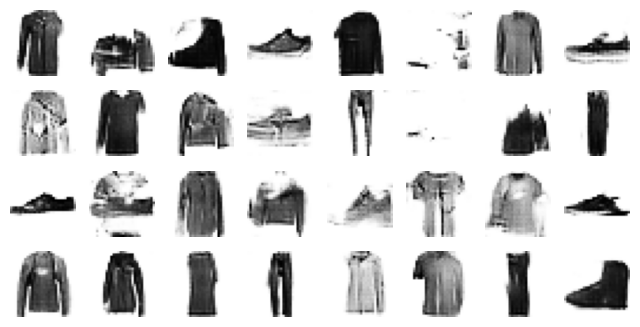

Duracion entrenamiento: 349.31548142433167


In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)